In [15]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib.pyplot as plt

In [29]:
class AI:
    def __init__(self, model_path: str):
        self.sess = rt.InferenceSession(model_path, providers=[
            'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

        self.input_name = self.sess.get_inputs()[0].name
        self.output_name = self.sess.get_outputs()[0].name
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img = (img - self.mean) / self.std
        img = np.transpose(img, (2, 0, 1))  # HWC -> CHW
        img = np.expand_dims(img, axis=0)  # Add batch dim
        return img.astype(np.float32)

    def postprocess_all_regression(self, detections: np.ndarray) -> np.ndarray:
        detections = np.squeeze(detections)
        return detections.astype(np.float32)
    
    def postprocess_regression_class(self, detections: np.ndarray) -> tuple:
        detections = np.squeeze(detections)  # shape: (4,)
        forward = float(detections[0])

        left_logits = detections[1:]
        left_class = int(np.argmax(left_logits))  # 0, 1, or 2

        # Optional: map class index to direction
        class_to_direction = { 0: -1, 1: 0, 2: 1}
        left = class_to_direction[left_class]

        return forward, left
    
    def postprocess_regression_class_5(self, detections: np.ndarray) -> tuple:
        detections = np.squeeze(detections)  # shape: (4,)
        forward = float(detections[0])

        left_logits = detections[1:]
        left_class = int(np.argmax(left_logits))  # 0, 1, or 2
        print(left_logits)
        print(left_class)

        # Optional: map class index to direction
        class_to_direction = { 0: -1, 1: -0.5, 2: 0, 3: 0.5, 4:1}
        left = class_to_direction[left_class]

        return forward, left

    def predict_all_regression(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)
        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        return self.postprocess_all_regression(detections)
    
    def predict_regression_class(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)
        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        return self.postprocess_regression_class(detections)
    
    def predict_regression_class_5(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)
        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        return self.postprocess_regression_class_5(detections)


def check(img_name):
    image_path = f'camera/{img_name}.png'
    image = cv2.imread(image_path)
    if image is None:
        image_path = f'camera/{img_name}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image '{image_path}' not found!")

    model_path = 'model_jetbot.onnx'
    ai = AI(model_path)
    """
    - ai.predict_all_regression()
    - ai.predict_regression_class()
    """

    prediction = ai.predict_regression_class_5(image)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Prediction: forward={prediction[0]:.3f}, left={prediction[1]:.3f}")
    plt.show()

    print(f'Prediction: forward={prediction[0]:.4f}, left={prediction[1]:.4f}')


In [30]:
# import numpy as np

# def show_preprocessed_image(preprocessed_img):
#     # preprocessed_img ma shape (1, 3, 224, 224)
#     img = preprocessed_img[0]  # usuń batch dimension -> (3, 224, 224)
    
#     # Transpozycja z powrotem do (224, 224, 3)
#     img = np.transpose(img, (1, 2, 0))
    
#     # Odwróć normalizację (zakładając, że normalizacja była:
#     # mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
    
#     img = (img * std) + mean
    
#     # Obcięcie wartości do zakresu [0,1]
#     img = np.clip(img, 0, 1)
    
#     plt.imshow(img)
#     plt.title("Obraz po preprocessingu")
#     plt.axis('off')
#     plt.show()


# # 1. Wczytaj oryginalny obraz i wyświetl
# image = cv2.imread('camera/0029.png')
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)
# plt.title("Oryginalny obraz")
# plt.axis('off')
# plt.show()

# # 2. Zrób preprocess
# def preprocess(img):
#     img = cv2.resize(img, (224, 224))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32) / 255.0
#     img = np.transpose(img, (2, 0, 1))
#     img = np.expand_dims(img, axis=0)
#     return img

# preprocessed_img = preprocess(image)

# # 3. Wyświetl obraz po preprocessingu (odwróć transformacje)
# show_preprocessed_image(preprocessed_img)



[ 13.1335125  -9.382444   11.124348  -16.300724   10.570869 ]
0


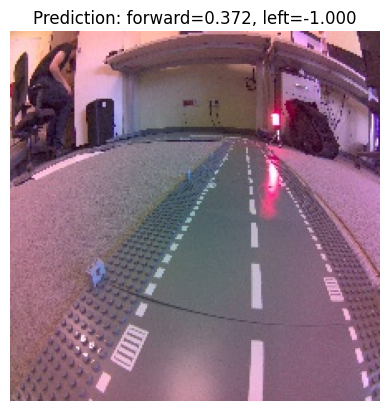

Prediction: forward=0.3723, left=-1.0000


In [31]:
check("0016")

[ 0.37043893 -0.3177824   0.19290955 -0.42857778  0.12734155]
0


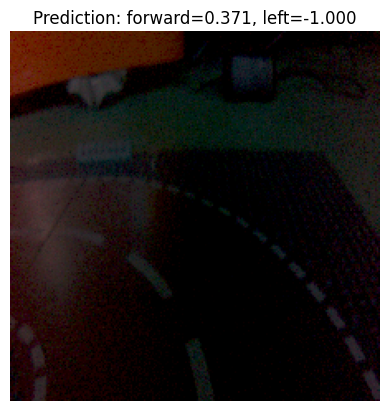

Prediction: forward=0.3707, left=-1.0000


In [32]:
check("1")

[ 0.51259387 -0.5188731   0.5263908  -0.7566819   0.47304258]
2


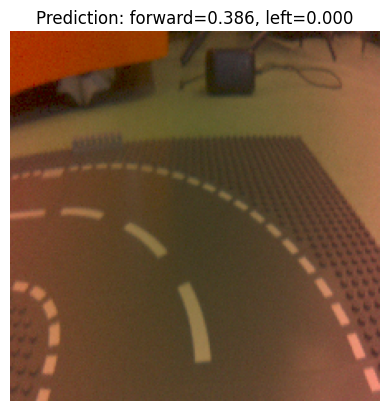

Prediction: forward=0.3861, left=0.0000


In [33]:
check(2)

[ 0.50852585 -0.37561733  0.43648556 -0.72217464  0.33576217]
0


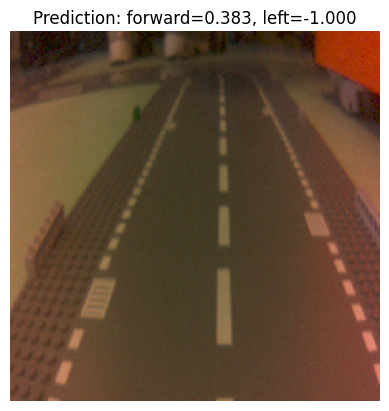

Prediction: forward=0.3829, left=-1.0000


In [34]:
check(3)

[ 0.54683566 -0.41762882  0.51848656 -0.79202545  0.40646115]
0


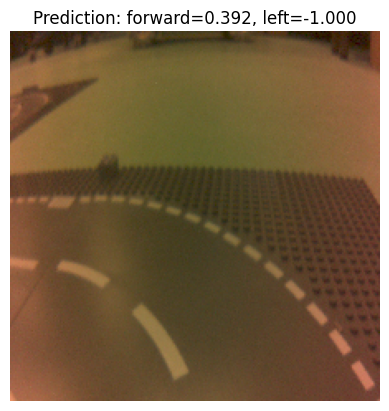

Prediction: forward=0.3925, left=-1.0000


In [35]:
check(4)

[ 13.30517    -6.1780705  14.860908  -20.369375   12.1886   ]
2


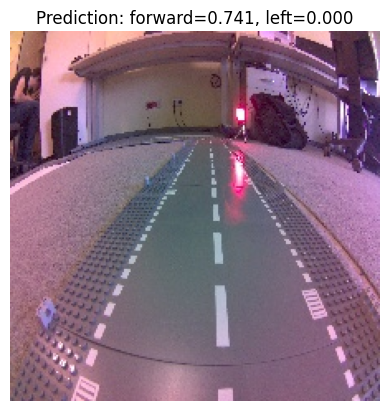

Prediction: forward=0.7408, left=0.0000


In [36]:
check("0029")

[ 2.472412  -2.736143   3.5011098 -3.7712626  3.3767507]


2


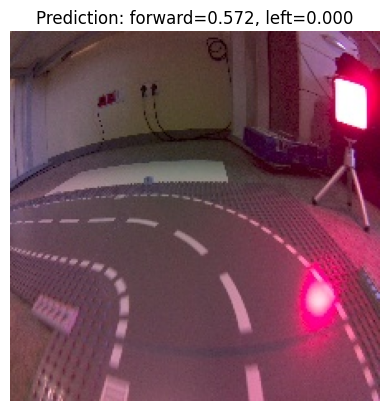

Prediction: forward=0.5719, left=0.0000


In [37]:
check("0086")

[ 21.273424   -7.2911506  15.545946  -25.18078    10.7573   ]
0


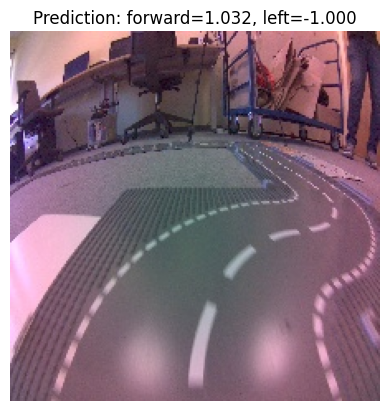

Prediction: forward=1.0315, left=-1.0000


In [38]:
check("0704")

[ 25.931639 -12.347003  23.336973 -33.40431   18.402718]
0


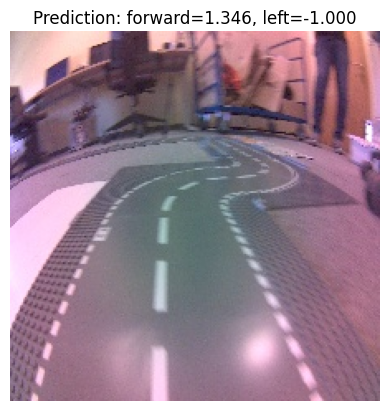

Prediction: forward=1.3464, left=-1.0000


In [39]:
check("0696")

[ 20.750505  -7.222489  15.144507 -24.499311  10.51386 ]
0


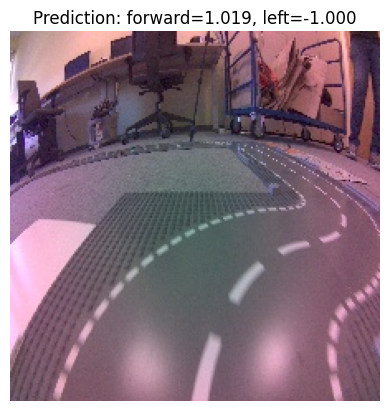

Prediction: forward=1.0192, left=-1.0000


In [40]:
check("0705")

[ 14.302166  -5.795487  11.072258 -17.410402   8.236295]
0


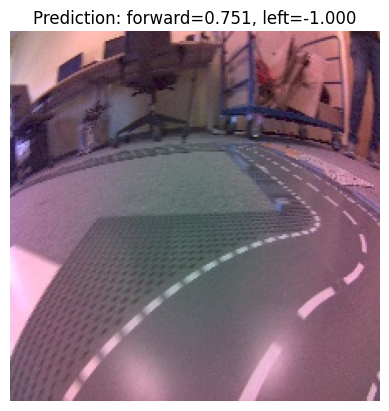

Prediction: forward=0.7509, left=-1.0000


In [41]:
check("0708")